In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
# TODO: Add denoising criterion; Representation spartsity

In [4]:
# Defining the dataset
class _dataset(Dataset): #
    def __init__(self, variant, category, random_seed=42, tensor=True):
        """ 
        variant -> 'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'
        category -> 'train, validation', 'test', 'all'
        tensor -> if true will return the data as a tensor, if False will return as a DataFrame
        """
        # TODO: Improve efficiency/handle names
        
        # Sanity checks
        assert variant in {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}, "Invalid variant!"
        assert category in {'train, validation', 'test', 'all'}, "Invalid category!"

        # With specified variant, get data
        file = join(processed_data_path, variant + ".csv")
        data = pd.read_csv(file, index_col=0)

        # Shuffle the dataframe
        data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

        # This will equally devide the dataset into 
        # train, validation and test
        train, validation, test = np.split(data.sample(frac=1), [int(len(data)*(1/3)), int(len(data)*(2/3))])
        
        if category == "train":
            data = train
        elif category == "validation":
            data = validation
        elif category == "test":
            data = test
        elif category == "all":
            del train, validation, test
            self.data = data
        
        # This data we want on a seperate variable
        if category != "all":
            # Weights
            if tensor:
                self.weights = torch.from_numpy(data["weights"].to_numpy(dtype=np.float32))
            else:
                self.weights = data["weights"]
            # Name
            self.name = data["name"]

            data.drop(["name", "weights"], axis=1, inplace=True)
            # Data
            if tensor:
                self.data = torch.from_numpy(data.to_numpy(dtype=np.float32))
            else:
                self.data = data
            self.n_samples = data.shape[0]


    def __getitem__(self, index):
        return self.data[index], self.weights[index]

    def __len__(self):
        return self.n_samples

    def all_data(self):
        return self.data

In [3]:
class VAE(pl.LightningModule):
    def __init__(self, dataset, batch_size, hidden_size, alpha, lr):
        """
        Args:
        - > variant e {'VLQ_HG', 'VLQ_SEM_HG', 'bkg', 'FCNC'}; it's the type of data
        - > hidden_size : Latent Hidden Size
        - > alpha : Hyperparameter to control the importance of
        reconstruction loss vs KL-Divergence Loss
        - > lr : Learning Rate, will not be used if auto_lr_find is used.
        - > dataset : Dataset to used
        """
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.hparams.batch_size = batch_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.alpha = alpha

        # Architecture
        self.encoder = nn.Sequential(
            nn.Linear(69, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, hidden_size),
            nn.LeakyReLU()
        )

        self.hidden2mu = nn.Linear(hidden_size, hidden_size)
        self.hidden2log_var = nn.Linear(hidden_size, hidden_size)
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 128), 
            nn.LeakyReLU(), 
            nn.Linear(128, 128),
            nn.LeakyReLU(), 
            nn.Linear(128, 69), 
            nn.LeakyReLU(),
        )

    def encode(self, x):
        # Pass through encoder
        out = self.encoder(x)
        mu = self.hidden2mu(out)
        log_var = self.hidden2log_var(out)
        return mu, log_var

    def decode(self, x):
        # Pass through encoder
        return self.decoder(x)

    def reparametrize(self, mu, log_var):
        # Reparametrization Trick
        # It outputs a sample of the dist.
        # mu -> average | log_var -> std
        
        log_var = torch.exp(0.5*log_var)
        z = torch.randn(size=(mu.size(0), mu.size(1))) # log_var, normal distribution
        z = z.type_as(mu)
        return mu + log_var*z

    def forward(self, x):
        # Pass through encoder
        mu, log_var = self.encode(x)
        # Reparametrization Trick
        hidden = self.reparametrize(mu, log_var)
        # Pass through decoder
        output = self.decoder(hidden)

        return mu, log_var, output, hidden

    def training_step(self, batch, batch_idx):
        x, weights = batch
        # Pass
        mu, log_var, x_out, _ = self.forward(x)

        # Losses
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)

        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)

        loss = recon_loss*self.alpha + kl_loss

        # Weights on final loss
        loss = (weights * loss) / weights.sum()
        loss = torch.mean(loss, dtype=torch.float32)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, weights = batch

        mu, log_var, x_out, _ = self.forward(x)

        # K-L Loss
        #kl_loss = (-0.5*(1+torch.log(log_var**2)-log_var**2 - mu**2).sum(dim=1)).mean(dim=0) 
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        # Weights on KL Loss
        kl_loss = (weights * kl_loss) / weights.sum()
        kl_loss = torch.mean(kl_loss, dtype=torch.float32)

        # Reconstruction loss
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        # Weights on recon loss
        recon_loss = (weights * recon_loss) / weights.sum()
        recon_loss = torch.mean(recon_loss, dtype=torch.float32)


        loss = recon_loss*self.alpha + kl_loss

        self.log('val_kl_loss', kl_loss, on_step=False, on_epoch=True)
        self.log('val_recon_loss', recon_loss, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        return x_out, loss

    def test_step(self, batch):
        ### WIP
        x = batch
        mu, log_var, x_out, hidden = self.forward(x)

        # Loss
        kl_loss = (-0.5*(1+log_var - mu**2 -
                         torch.exp(log_var)).sum(dim=1)).mean(dim=0)
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss*self.alpha + kl_loss

        return hidden

    def validation_epoch_end(self, outputs):
        pass

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    # Functions for dataloading
    def train_dataloader(self):
        train_set = _dataset(self.dataset, category="train")
        return DataLoader(train_set, batch_size=self.batch_size, num_workers=12)

    def val_dataloader(self):
        val_set = _dataset(self.dataset, category="validation")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)

    def test_dataloader(self):
        val_set = _dataset(self.dataset, category="test")
        return DataLoader(val_set, batch_size=self.batch_size, num_workers=12)


In [ ]:

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

if __name__ == "__main__":
    logger = TensorBoardLogger("lightning_logs")
    trainer = Trainer(
        # fast_dev_run = True,
        gpus=1,
        #auto_lr_find=True,
        max_epochs=500,
        #max_time=
        callbacks=[EarlyStopping(monitor="val_loss", patience=100), ModelCheckpoint(dirpath="models", monitor="val_loss", mode="min")],
        logger=logger,
        precision=16
        )
    model = VAE(
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001,
    )
    #trainer.tune(model) 
    trainer.fit(model)


### Load Model

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
model = VAE.load_from_checkpoint(
    "./models/epoch=455-step=82535.ckpt", 
    dataset = "bkg",
    hidden_size=2,
    batch_size = 2048,
    alpha = 10, 
    lr = 0.0001)


In [6]:
model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (hidden2mu): Linear(in_features=2, out_features=2, bias=True)
  (hidden2log_var): Linear(in_features=2, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=69, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)

Load data

In [79]:
# Sinal
data = pd.concat([
     _dataset(category='all',variant='VLQ_HG').all_data()
    ,_dataset(category='all',variant='VLQ_SEM_HG').all_data()
    ,_dataset(category='all',variant='FCNC').all_data()
    ])

# Bkg
bkg = _dataset(category='test',variant='bkg', tensor=False).all_data()
bkg['name'] = 'background.csv'
data = pd.concat([data, bkg])

data.drop(columns=['weights'], inplace=True)
data.describe()


/home/acujl/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron_Multi,Electron1_PT,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT
count,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,...,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000,527817.000000
mean,0.000044,-0.000598,-0.001030,-0.000534,0.001826,0.000198,-0.000853,0.000422,0.000719,0.002378,...,-0.000989,-0.001713,-0.001219,-0.000658,-0.000813,-0.002657,-0.000071,-0.000144,0.000739,-0.000891
std,1.000482,0.999518,0.999568,0.997474,1.012935,1.012466,0.999439,1.001952,1.002345,1.031440,...,0.999454,0.998652,0.999273,0.999072,0.998227,0.999455,0.999047,1.000900,0.999442,0.999786
min,-5.319242,-4.101005,-2.998802,-1.426919,-0.605231,-0.189027,-3.535722,-2.437524,-1.199560,-0.539097,...,-1.336158,-1.218623,-0.673532,-4.252402,-5.476268,-2.822515,-4.058638,-1.521113,-1.755112,-2.533251
25%,-0.506770,-0.582566,-0.856784,-0.459476,-0.129339,-0.031524,-0.786148,-0.742107,-0.388786,-0.113399,...,-0.810386,-0.710694,-0.534342,-0.005541,-0.004436,-0.004365,-0.000624,-0.663039,-0.862991,-0.705042
50%,-0.114884,-0.042598,-0.132677,-0.220869,-0.096728,-0.024664,-0.067849,-0.331509,-0.193727,-0.086368,...,-0.781252,-0.572371,-0.487050,0.000813,-0.000362,-0.000101,0.001715,-0.274627,-0.000934,-0.242449
75%,0.791427,0.537016,0.704503,-0.171740,-0.047287,-0.010815,0.634855,0.580857,-0.151859,-0.041419,...,1.198572,0.531724,0.180409,0.007525,0.001253,0.008770,0.005244,0.369543,0.867078,0.446953
max,9.401355,20.110285,13.707274,21.165312,40.369312,193.081823,19.367462,14.350854,23.570461,73.473393,...,4.526157,11.705100,14.925601,4.244512,5.479251,2.827602,4.049156,19.050344,1.777218,17.698510


Plot

  0%|          | 0/6 [00:00<?, ?it/s]

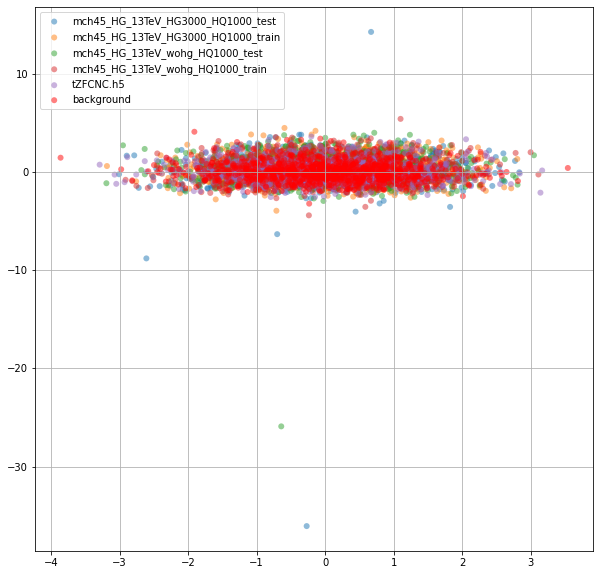

In [89]:
fig, ax = plt.subplots( figsize=(10,10))
for x in tqdm(data['name'].unique()):
    hidden = model.test_step(torch.from_numpy(data.loc[data['name'] == x].drop(columns=['name']).to_numpy(dtype=np.float32))).detach().numpy()

    if x != 'background.csv':
        color = None
    else:
        color = 'r'

    ax.scatter(hidden[:1000, 0], hidden[:1000, 1], label=x.replace('.csv', ''), alpha=0.5, edgecolors='none', c = color)

ax.legend()
ax.grid(True)

plt.show()
